In [1]:
%matplotlib notebook

import json
import numpy as np
import numpy.random as npr
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as mpt

from ast import literal_eval

In [2]:
INIT_STOP = 200
TSTOP = 1200
NTRAJ = 64
NPOINTS = 120
THRES = 0.1
BURN_IN = 20
SPECIES = ['RNA', 'P']

base_parameters = {
    'k_a': 0.002,
    'k_d': 0.1,
    'mu': 3.0,
    'kappa': 1.0,
    'gamma': 0.04,
    'diffusion': 0.6,
    'time_step': 0.1,
    'cell_radius': 6.0,
    'nucleus_radius': 2.5,
}

def log_value(p, name=None):
    return (np.log10(base_parameters[name]) if name else 0) + p * np.log10(2)

def exp_value(p, name=None):
    return (p - (np.log10(base_parameters[name]) if name else 0))/np.log10(2)

In [3]:
with open('../data.json', 'r') as f:
    raw_data = {literal_eval(k): v for k, v in json.load(f).items()}
    
for key in raw_data.keys():
    solver, params = key
    timeseries = raw_data[key][1]
            
    if solver == 'CBM':
        for species in ['P', 'RNA']:
            timeseries[species] = np.array(timeseries[species + 'nuc']) + np.array(timeseries[species + 'cyt'])
            del timeseries[species + 'nuc']
            del timeseries[species + 'cyt']
    
    del timeseries['Gf']
    del timeseries['Gb']
    
    for species in timeseries:
        timeseries[species] = np.array(timeseries[species])[:, BURN_IN:]
        
# Refactor data
data = {}
for k, v in raw_data.items():
    solver, params = k
    data.setdefault(params, {})[solver] = v

<IPython.core.display.Javascript object>


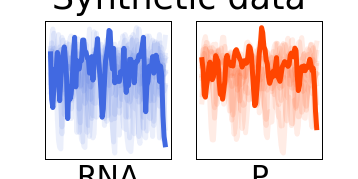

<IPython.core.display.Javascript object>


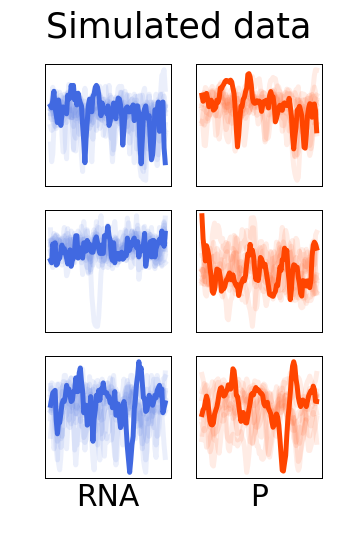

In [20]:
params = {'legend.fontsize': 20,
         'figure.figsize': (4, 2),
         'figure.titlesize': 28,
         'axes.labelsize': 24,
         'text.usetex':False,
         'figure.autolayout':False,
         }

plt.rcParams.update(params)

keys = sorted([k for k in data.keys() if k[2] == 0.0], key=lambda k: (k[1], k[0]))
keys = [keys[i] for i in [125, 121, 100, 90]]

alpha = 0.1
width = 4

key = keys[0]
fig, ax = plt.subplots(1, 2)
t = np.linspace(0, TSTOP - INIT_STOP, num=NPOINTS - BURN_IN + 1)
for i, species in enumerate(SPECIES):
    ax[i].plot(t, np.array(data[key]['smoldyn'][1][species])[0, :].T,
                'orangered' if i else 'royalblue', label=species, linewidth=width)
    ax[i].plot(t, np.array(data[key]['smoldyn'][1][species])[1:10, :].T,
                'orangered' if i else 'royalblue', label=species, linewidth=width, alpha=alpha)
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
    ax[i].set_xlabel(species)
fig.suptitle("Synthetic data", y=1.10)
plt.savefig(f"synthdat.pdf", bbox_inches='tight')

params = {'legend.fontsize': 20,
         'figure.figsize': (4, 6),
         'figure.titlesize': 28,
         'axes.labelsize': 24,
         'text.usetex':False,
         'figure.autolayout':False,
         }

plt.rcParams.update(params)

fig, ax = plt.subplots(len(keys[1:]), 2)
for j, key in enumerate(keys[1:]):
    t = np.linspace(0, TSTOP - INIT_STOP, num=NPOINTS - BURN_IN + 1)
    for i, species in enumerate(SPECIES):
        ax[j, i].plot(t, np.array(data[key]['smoldyn'][1][species])[0, :].T,
                    'orangered' if i else 'royalblue', label=species, linewidth=width)
        ax[j, i].plot(t, np.array(data[key]['smoldyn'][1][species])[1:10, :].T,
                    'orangered' if i else 'royalblue', label=species, linewidth=width, alpha=alpha)
        ax[j, i].get_xaxis().set_ticks([])
        ax[j, i].get_yaxis().set_ticks([])
        if j == len(keys[1:]) - 1:
            ax[j, i].set_xlabel(species)
    fig.suptitle("Simulated data")
plt.savefig(f"simdat.pdf", bbox_inches='tight')
    

In [5]:
summary_statistics_raw = {
        'mean': lambda x: np.mean(x, axis=1).mean(),
        'std': lambda x: np.std(x, axis=1).mean(),
        'min': lambda x: np.min(x, axis=1).mean(),
        'max': lambda x: np.max(x, axis=1).mean(),
        }

stat_mean = {'meanP': 1042.154285695293, 'meanRNA': 61.844218439788314, 'stdP': 255.5303176575153, 'stdRNA': 15.336083154554037, 'minP': 467.9661153157552, 'minRNA': 25.877583821614582, 'maxP': 1496.834452311198, 'maxRNA': 91.36317952473958}
stat_std = {'meanP': 526.6189072354466, 'meanRNA': 11.768310207409813, 'stdP': 187.71013670846963, 'stdRNA': 6.797565421631525, 'minP': 443.51772696920216, 'minRNA': 20.602305740635945, 'maxP': 709.1671367023749, 'maxRNA': 4.990071149032393}


summary_statistics = {
            k + species: lambda x: (s(x) - stat_mean[k + species])/stat_std[k + species]
            for k, s in summary_statistics_raw.items()
            for species in SPECIES
        }

lst_square = lambda x,y: (
        (np.array([summary_statistics[k + species](x[species])
                   for k in summary_statistics_raw.keys()
                   for species in SPECIES])
        - (np.array([summary_statistics[k + species](y[species])
                   for k in summary_statistics_raw.keys()
                   for species in SPECIES]))
    )**2).sum()**0.5


In [6]:
synthetic_data = keys[0]
def train_surrogate_dist(target, solver, data):
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel, RBF, WhiteKernel, Matern
    from sklearn import preprocessing
    
    x_scaler = preprocessing.MinMaxScaler()
    y_scaler = preprocessing.MinMaxScaler()

    
    X = [k for k in data.keys() if k[2]==0.] # Ignore k_d
    y = np.array([
         lst_square(data[target]['smoldyn'][1], data[tuple(k)][solver][1])
         for k in X
        ])
        
    kernel = (
        #ConstantKernel() +
        RationalQuadratic()
        #Matern()
        #+ RBF()
        + WhiteKernel()
    )
    gp = GaussianProcessRegressor(
        kernel=kernel,
        #alpha=np.array([var_ss_dist[solver][k] for k in X]),
        n_restarts_optimizer=10,
    )
    
    X_raw = np.array(X)[:, :2]
    x_scaler.fit(X_raw)
    X_norm = x_scaler.transform(X_raw)
    
    y = np.atleast_2d(y).T
    y_scaler = y_scaler.fit(y)
    y_norm = y_scaler.transform(y)
        
    gp.fit(X_norm, y_norm)
    
    return (gp, x_scaler, y_scaler)

gp, x_scl, y_scl = train_surrogate_dist(synthetic_data, 'smoldyn', data)
y_scl.inverse_transform(gp.predict(x_scl.transform(np.atleast_2d(synthetic_data[:2])), return_std=True))

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


array([[0.0330562 ],
       [0.05024368]])

In [7]:
ss_dist = {solver:
           {k:
              lst_square(data[synthetic_data]['smoldyn'][1], v[solver][1])
              for k, v in data.items()
              if 'smoldyn' in v and solver in v
              }
           for solver in ['smoldyn']
          }

<IPython.core.display.Javascript object>


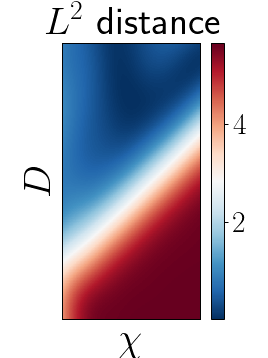

In [11]:
params = {
         'figure.figsize': (3, 4),
         'figure.titlesize': 32,
         'axes.labelsize': 32,
         'axes.titlesize':28,
         'xtick.labelsize':28,
         'ytick.labelsize':24,
         'text.usetex':True,
         'figure.autolayout':False,
         }

plt.rcParams.update(params)

import scipy.interpolate as sci
import matplotlib.colors as colors

fig, ax = plt.subplots()
#fig.tight_layout(w_pad=0)

solver = 'smoldyn'
dist = ss_dist

dist_sol = dist[solver]

min_x = log_value(min(dist_sol.keys(), key=lambda t: t[1])[1])
max_x = log_value(max(dist_sol.keys(), key=lambda t: t[1])[1])
min_D = log_value(min(dist_sol.keys(), key=lambda t: t[0])[0], 'diffusion')
max_D = log_value(max(dist_sol.keys(), key=lambda t: t[0])[0], 'diffusion')

raw_grid = np.array([[log_value(chi), log_value(D, 'diffusion'), z]
                     for ((D, chi, k_d), z) in dist_sol.items()
                    if k_d == 0])


gp, x_scl, y_scl = train_surrogate_dist(synthetic_data, solver, data)

xi, yi = np.mgrid[min_x:max_x:100j, min_D:max_D:100j]
xi = exp_value(xi)
yi = exp_value(yi, 'diffusion')
X_test = x_scl.transform(
    np.concatenate((yi.reshape(-1)[:, np.newaxis], xi.reshape(-1)[:, np.newaxis]), axis=1))
#OBS input must be passed as (D, Chi) to the gaussian process
grid_z2 = y_scl.inverse_transform(np.atleast_2d(gp.predict(X_test, return_std=True)[0]).T).reshape(xi.shape)

pcm = ax.imshow(grid_z2.T, extent=(min_x, max_x, min_D, max_D),
           #norm=colors.LogNorm(),
           #vmin=0, vmax=1000,
           origin='lower', cmap='RdBu_r')

ax.set_ylabel('$D$')

ax.set_xlabel('$\chi$')

#ax.set_title(f"{solver}")

#xticks = list(range(int(np.ceil(min_x)), int(np.floor(max_x))+1))
#ax.set_xticks(xticks)
#ax.set_xticklabels([f'$10^{{{t}}}$' for t in xticks])
#ax.xaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))
#yticks = list(range(int(np.ceil(min_D)), int(np.floor(max_D))+1))
#ax.set_yticks(yticks)
#ax.set_yticklabels([f'$10^{{{t}}}$' for t in yticks])
#ax.yaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))
#ax.scatter(log_value(synthetic_data[1]), log_value(synthetic_data[0], 'diffusion'))
 
    
ax.set_xticks([])
ax.set_yticks([])

cb = fig.colorbar(pcm, ax=ax)
                  #location='right', shrink=0.7)
#cb.set_label('$L^2$ distance')

fig.suptitle('$L^2$ distance')
plt.savefig('dist.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


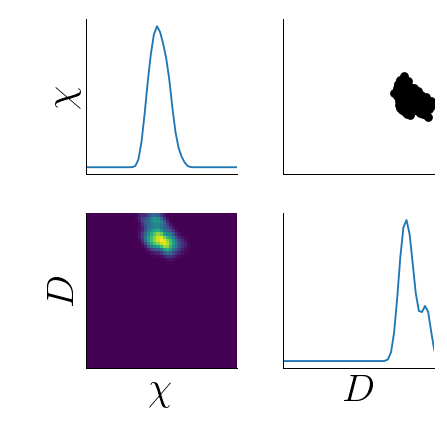

/home/adrien/Documents/Library/anaconda3/lib/python3.8/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)


In [12]:
import pyabc
import parse
import numpy as np

inference_file = f"../ss/ss_all_hh/inference_{synthetic_data}_smoldyn.db".replace(' ', '')

bounds = {
    "chi": (-2, 4),
    "diffusion": (-8, 4),
}

from pyabc.visualization import plot_kde_matrix_highlevel
import matplotlib.pyplot as plt
import matplotlib.ticker as mpt

params = {
      'figure.figsize': (4, 4),
      'axes.labelsize': 32,
      'axes.titlesize':24,
      'xtick.labelsize':15,
      'ytick.labelsize':15,
      'text.usetex':True,
     }

plt.rcParams.update(params)

db_path = "sqlite:///{}".format(inference_file)
history = pyabc.History(db_path)

ax = plot_kde_matrix_highlevel(history,
            limits=bounds, colorbar=False,
            #refval={'diffusion': 0.8, 'chi': 0.8},
        )

ax[1, 0].set_xlabel('$\chi$')
ax[0, 0].set_ylabel('$\chi$')

ax[1, 0].set_ylabel('$D$')
ax[1, 1].set_xlabel('$D$')

for i in [0, 1]:
    for j in [0, 1]:
        ax[i, j].get_xaxis().set_ticks([])
        ax[i, j].get_yaxis().set_ticks([])
        
plt.savefig('kde.pdf', bbox_inches='tight')